<a href="https://colab.research.google.com/github/itacademy-rogergallart/base_de_dades/blob/main/S17_T02_Base_de_dades_MySQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S17 T02 : Base de dades MySQL


## Exercici 1

Crea una base de dades relacionals senzilla utilitzant MySQL(https://www.mysql.com/) i connecta-la a Python

Nota: Aquest notebook està pensat per ser executat a Google Colab. Per això inclou la instal·lació de MySQL a la màquina remota, etc.

### Setup

In [1]:
# Update apt
!apt-get update &> /dev/null

# Install MySQL server
!apt-get install mysql-server &> /dev/null

In [2]:
# Run MySQL server
!service mysql start

 * Starting MySQL database server mysqld
No directory, logging in with HOME=/
   ...done.


In [ ]:
# We create a new user with full privileges
!mysql -e "CREATE USER 'roger'@'localhost' IDENTIFIED BY '1234';"
!mysql -e "GRANT ALL PRIVILEGES ON *.* TO 'roger'@'localhost';" 

In [3]:
# Install MySQL-connector package
!pip install mysql-connector-python > /dev/null

In [4]:
# Imports
import mysql.connector as mysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Creació de base de dades *covid_vaccinations*

In [11]:
# Dictionary containing the connection parameters
config = {
    'host' : '127.0.0.1',      # IP address of the MySQL database server
    'user' : 'roger',           # User name of the database server
    'password' : '1234',           # Password for the database user
    'autocommit' : True
}

In [12]:
# Create the new database: covid_vaccinations

create_db_query = "CREATE DATABASE IF NOT EXISTS covid_vaccinations"

try:
  with mysql.connect(**config) as connection:
    with connection.cursor() as c:
      c.execute(create_db_query)
except mysql.Error as e:
    print(e)

In [13]:
# Add the database name to the dictionary containing the connection parameters

config['database']='covid_vaccinations'

### Creació de taula *vaccinations*
Conté informació setmanal sobre les vacunes contra la covid-19 comprades pels paisos Europeus, administrades en primera o segona dosi, per rangs d'edat, etc.

Més informació: https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea

In [15]:
# Download CSV dataset file from my personal github
# Data source: https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea
# This CSV contains information about the covid-19 vaccines used weekly in European countries 

# Note: the file is copied to the /var/lib/mysql-files/ folder in order to be
# able to upload it later into the MySQL database without security issues

!wget -P /var/lib/mysql-files/ https://raw.githubusercontent.com/itacademy-rogergallart/base_de_dades/main/data.csv

--2021-10-06 12:21:21--  https://raw.githubusercontent.com/itacademy-rogergallart/base_de_dades/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4248528 (4.1M) [text/plain]
Saving to: ‘/var/lib/mysql-files/data.csv’

data.csv            100%[===================>]   4.05M  --.-KB/s    in 0.07s   

2021-10-06 12:21:21 (54.3 MB/s) - ‘/var/lib/mysql-files/data.csv’ saved [4248528/4248528]



In [16]:
# Create main table (vaccinations) and load data from the CSV file

create_table_query = """
CREATE TABLE vaccinations (
    id INT NOT NULL AUTO_INCREMENT,
    year_week_ISO CHAR(8) NULL,
    first_dose INT NULL,
    first_dose_refused INT NULL, 
    second_dose INT NULL,
    unknown_dose INT NULL,
    number_doses_received INT NULL,
    region VARCHAR(8) NULL,
    population INT NULL,
    reporting_country CHAR(2) NULL,
    target_group ENUM('ALL', 'Age<18', 'HCW', 'LTCF', 'Age0_4', 'Age5_9', 'Age10_14', 'Age15_17', 'Age18_24',
    'Age25_49', 'Age50_59', 'Age60_69', 'Age70_79', 'Age80+', 'AgeUnk', '1_Age<60', '1_Age60+'),
    vaccine_id VARCHAR(8) NULL,
    denominator INT NULL,
    PRIMARY KEY (id)
);
"""

load_data_query = """
LOAD DATA INFILE '/var/lib/mysql-files/data.csv' 
INTO TABLE vaccinations
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\r\n'
IGNORE 1 ROWS
(year_week_ISO, @first_dose, @first_dose_refused, @second_dose, @unknown_dose, @number_doses_received, region, population, reporting_country, target_group, vaccine_id, @denominator)
SET first_dose = NULLIF(@first_dose,''),
    first_dose_refused = NULLIF(@first_dose_refused,''),
    second_dose = NULLIF(@second_dose,''),
    unknown_dose = NULLIF(@unknown_dose,''),
    number_doses_received = NULLIF(@number_doses_received,''),
    denominator = NULLIF(@denominator,'');
"""
# Comments:
# - \r\n intead of \n used to deal with some rows of CSV where the last field (column) is empty
# - NULLIF(...) statements used to import empty fields in the CSV as NULL fields in the table

try:
  
  with mysql.connect(**config) as connection:
    with connection.cursor() as c:
      c.execute("DROP TABLE IF EXISTS vaccinations")  # If the table already exists, we delete it
      c.execute(create_table_query)
      c.execute(load_data_query)

except mysql.Error as e:
    print(e)

In [17]:
# Check that data has correctly been loaded into the "vaccinations" table by printing
# the first 5 rows

with mysql.connect(**config) as connection:

  with connection.cursor() as c:  

    c.execute('SELECT * FROM vaccinations LIMIT 10')
    data = c.fetchall()
    print("Column names: ", c.column_names, "\n")
    print("First 5 rows:")
    for row in data: print(row)


Column names:  ('id', 'year_week_ISO', 'first_dose', 'first_dose_refused', 'second_dose', 'unknown_dose', 'number_doses_received', 'region', 'population', 'reporting_country', 'target_group', 'vaccine_id', 'denominator') 

First 5 rows:
(1, '2020-W53', 2848, None, 0, 0, 61425, 'AT', 8901064, 'AT', '1_Age60+', 'COM', 2259262)
(2, '2020-W53', 0, None, 0, 0, 0, 'AT', 8901064, 'AT', '1_Age60+', 'UNK', 2259262)
(3, '2020-W53', 0, None, 0, 0, 0, 'AT', 8901064, 'AT', '1_Age60+', 'JANSS', 2259262)
(4, '2020-W53', 0, None, 0, 0, 0, 'AT', 8901064, 'AT', '1_Age60+', 'AZ', 2259262)
(5, '2020-W53', 0, None, 0, 0, 0, 'AT', 8901064, 'AT', '1_Age60+', 'MOD', 2259262)
(6, '2020-W53', 0, None, 0, 0, 0, 'AT', 8901064, 'AT', '1_Age<60', 'MOD', 5099181)
(7, '2020-W53', 0, None, 0, 0, 0, 'AT', 8901064, 'AT', '1_Age<60', 'UNK', 5099181)
(8, '2020-W53', 2372, None, 1, 0, 61425, 'AT', 8901064, 'AT', '1_Age<60', 'COM', 5099181)
(9, '2020-W53', 0, None, 0, 0, 0, 'AT', 8901064, 'AT', '1_Age<60', 'JANSS', 5099181)

La columna year_week_ISO ha de tenir el format **yyyy**-W**xx** on yyyy és l'any i xx la setmana. Per assegurar que no es pugui entrar dades en aquest camp amb un format incorrecte, podem implementar un TRIGGER. Cal crear triggers separats per UPDATE i per INSERT. Per no repetir codi, el posem en una PROCEDURE que cridem des de cada trigger.

In [18]:
# Triggers to validate the date format (yyyy-Wxx where yyyy=year and xx=week number)
# before inserting or updating a row

trigger_query="""
DROP PROCEDURE IF EXISTS validate_date;
DROP TRIGGER IF EXISTS trig_insert;
DROP TRIGGER IF EXISTS trig_update;

CREATE PROCEDURE validate_date(year_week_ISO CHAR(8))
BEGIN 
IF (year_week_ISO REGEXP '^[0-9]{4}-W[0-9]{2}$' ) = 0 THEN 
  SIGNAL SQLSTATE '12345'
     SET MESSAGE_TEXT = 'Non-valid year_week_ISO value. The correct format should be yyyy-Wxx where yyyy=4-digit year and xx=2-digit week number !!!';
END IF;
END;

CREATE TRIGGER trig_insert BEFORE INSERT ON vaccinations
FOR EACH ROW 
BEGIN 
  CALL validate_date(NEW.year_week_ISO);
END;

CREATE TRIGGER trig_update BEFORE UPDATE ON vaccinations
FOR EACH ROW 
BEGIN 
  CALL validate_date(NEW.year_week_ISO);
END;
"""

with mysql.connect(**config) as connection:
  with connection.cursor() as c:  
    c.execute(trigger_query, multi=True)  

In [19]:
# We check that the triggers have been created on the database
with mysql.connect(**config) as connection:
  with connection.cursor() as c:  
    c.execute('SHOW TRIGGERS LIKE "vaccinations"')
    for i in c.fetchall(): print(i)

('trig_insert', 'INSERT', 'vaccinations', 'BEGIN \n  CALL validate_date(NEW.year_week_ISO);\nEND', 'BEFORE', datetime.datetime(2021, 10, 6, 12, 22, 7, 230000), 'ONLY_FULL_GROUP_BY,STRICT_TRANS_TABLES,NO_ZERO_IN_DATE,NO_ZERO_DATE,ERROR_FOR_DIVISION_BY_ZERO,NO_AUTO_CREATE_USER,NO_ENGINE_SUBSTITUTION', 'roger@localhost', 'utf8mb4', 'utf8mb4_general_ci', 'latin1_swedish_ci')
('trig_update', 'UPDATE', 'vaccinations', 'BEGIN \n  CALL validate_date(NEW.year_week_ISO);\nEND', 'BEFORE', datetime.datetime(2021, 10, 6, 12, 22, 7, 240000), 'ONLY_FULL_GROUP_BY,STRICT_TRANS_TABLES,NO_ZERO_IN_DATE,NO_ZERO_DATE,ERROR_FOR_DIVISION_BY_ZERO,NO_AUTO_CREATE_USER,NO_ENGINE_SUBSTITUTION', 'roger@localhost', 'utf8mb4', 'utf8mb4_general_ci', 'latin1_swedish_ci')


In [20]:
# We test an invalid year_week_ISO value to check that the triggers are working
query="""
INSERT INTO vaccinations (year_week_ISO, first_dose, first_dose_refused, second_dose, unknown_dose, number_doses_received, region, population, reporting_country, target_group, vaccine_id, denominator) 
VALUES ('aa33-W33', 1, 1, 1, 1, 1, 'AT', 1, 'AT', 'ALL', 'AZ', 1)
"""
try:
  with mysql.connect(**config) as connection:
    with connection.cursor() as c:  
      c.execute(query)
except mysql.Error as e:
    print(e)

1644 (12345): Non-valid year_week_ISO value. The correct format should be yyyy-Wxx where yyyy=4-digit year and xx=2-digit week number !!!


### Creació de la taula *vaccines*
Aquesta taula conté informació sobre les vacunes contra la covid-19 aprovades a Europa incloent el nom, fabricant i tipus de vacuna.

In [21]:
# We create another table called "vaccines" with the information about each vaccine (code, name, manufacturer, type)
# Source: https://covid19.trackvaccines.org/vaccines/approved/

create_table_vaccines_query = """
CREATE TABLE vaccines (
    vaccine_id VARCHAR(10) UNIQUE NOT NULL,
    name VARCHAR(20),
    manufacturer VARCHAR(30),
    type ENUM('Protein Subunit', 'Virus-like Particles', 'DNA-based', 'RNA-based', 'Non Replicating Viral Vector', 'Replicating Viral Vector', 'Inactivated', 'Live-Attenuated', 'Unknown'),
    PRIMARY KEY (vaccine_id)
);
"""

insert_vaccines_query = "INSERT INTO vaccines (vaccine_id, name, manufacturer, type) VALUES (%s, %s, %s, %s)"

vaccines_values = [
  ('AZ', 'Vaxzevria', 'Oxford/AstraZeneca', 'Non Replicating Viral Vector'),
  ('BECNBG', 'BBIBP-CorV', 'Beijing CNBG', 'Inactivated'),
  ('BHACOV', 'Covaxin', 'Bharat Biotech', 'Inactivated'),
  ('COM', 'Comirnaty', 'Pfizer/BioNTech', 'RNA-based'),
  ('JANSS', 'Ad26.COV 2.5', 'Janssen', 'Non Replicating Viral Vector'),
  ('HAYATVAC', 'Hayat Vax', 'Sinopharm', 'Inactivated'),
  ('MOD', 'mRNA-1273', 'Moderna', 'RNA-based'),
  ('QAZVAQ', 'QazCovid-In', 'Kazakhstan RIBSP', 'Inactivated'),
  ('SIICOV', 'Covishield', 'Serum Institute of India', 'Non Replicating Viral Vector'),
  ('SIN', 'CoronaVac', 'Sinovac', 'Inactivated'),
  ('SPU', 'Sputnik V', 'Gamaleya', 'Non Replicating Viral Vector'),
  ('SRCVB', 'EpiVacCorona', 'SRCVB', 'Protein Subunit'),
  ('WUCNBG', 'Inactivated', 'Wuhan CNBG', 'Inactivated'),
  ('UNK', 'Unknown', 'Unknown', 'Unknown'),
  ('ZFUZ', 'Sino-Uzbek', 'ZF-UZVAC', 'Inactivated')
]

try:

  with mysql.connect(**config) as connection:
    with connection.cursor() as c:
      c.execute("DROP TABLE IF EXISTS vaccines")  # If the table already exists, we delete it
      c.execute(create_table_vaccines_query)
      c.executemany(insert_vaccines_query, vaccines_values)

except mysql.Error as e:
    print(e)


In [22]:
# Check that data has correctly been loaded into the "vaccines" table

with mysql.connect(**config) as connection:

  with connection.cursor() as c:

    c.execute('SELECT * FROM vaccines')
    data = c.fetchall()
    print("Column names: ", c.column_names, "\n")
    for row in data: print(row)


Column names:  ('vaccine_id', 'name', 'manufacturer', 'type') 

('AZ', 'Vaxzevria', 'Oxford/AstraZeneca', 'Non Replicating Viral Vector')
('BECNBG', 'BBIBP-CorV', 'Beijing CNBG', 'Inactivated')
('BHACOV', 'Covaxin', 'Bharat Biotech', 'Inactivated')
('COM', 'Comirnaty', 'Pfizer/BioNTech', 'RNA-based')
('HAYATVAC', 'Hayat Vax', 'Sinopharm', 'Inactivated')
('JANSS', 'Ad26.COV 2.5', 'Janssen', 'Non Replicating Viral Vector')
('MOD', 'mRNA-1273', 'Moderna', 'RNA-based')
('QAZVAQ', 'QazCovid-In', 'Kazakhstan RIBSP', 'Inactivated')
('SIICOV', 'Covishield', 'Serum Institute of India', 'Non Replicating Viral Vector')
('SIN', 'CoronaVac', 'Sinovac', 'Inactivated')
('SPU', 'Sputnik V', 'Gamaleya', 'Non Replicating Viral Vector')
('SRCVB', 'EpiVacCorona', 'SRCVB', 'Protein Subunit')
('UNK', 'Unknown', 'Unknown', 'Unknown')
('WUCNBG', 'Inactivated', 'Wuhan CNBG', 'Inactivated')
('ZFUZ', 'Sino-Uzbek', 'ZF-UZVAC', 'Inactivated')


## Exercici 2

Mostra que pots carregar algunes consultes senzilles a un Pandas Dataframe

In [23]:
# Connection instance
conn = mysql.connect(**config)

**- Consulta 1:** nombre de dosis setmanals de tots els tipus de vacunes contra la covid-19 administrades a Espanya

In [24]:
query1 = """
SELECT year_week_ISO AS week, manufacturer AS vaccine, SUM(first_dose) AS total_first_dose, 
      SUM(first_dose_refused) AS total_first_dose_refused, 
      SUM(second_dose) AS total_second_dose,
      MAX(population) AS population 
FROM vaccinations LEFT JOIN vaccines USING (vaccine_id)
GROUP BY vaccine_id, reporting_country, year_week_ISO, target_group
HAVING reporting_country='ES' AND target_group='ALL'
ORDER BY year_week_ISO, vaccine_id;
"""
df1 = pd.read_sql(query1, conn)
print(f"Number of weekly vaccine doses in Spain - Total #rows: {df1.size}")
df1.head(10)

Number of weekly vaccine doses in Spain - Total #rows: 888


,week,vaccine,total_first_dose,total_first_dose_refused,total_second_dose,population
0,2020-W53,Oxford/AstraZeneca,0.0,0.0,0.0,47332614
1,2020-W53,Pfizer/BioNTech,96347.0,528.0,0.0,47332614
2,2020-W53,Janssen,0.0,0.0,0.0,47332614
3,2020-W53,Moderna,0.0,0.0,0.0,47332614
4,2021-W01,Oxford/AstraZeneca,0.0,0.0,0.0,47332614
5,2021-W01,Pfizer/BioNTech,323223.0,1156.0,0.0,47332614
6,2021-W01,Janssen,0.0,0.0,0.0,47332614
7,2021-W01,Moderna,0.0,0.0,0.0,47332614
8,2021-W02,Oxford/AstraZeneca,0.0,0.0,0.0,47332614
9,2021-W02,Pfizer/BioNTech,498851.0,1099.0,2035.0,47332614


**- Consulta 2:** nombre de dosis setmanals de vacuna Oxford/Astrazeneca (AZ) administrades a Espanya a gent major i menor de 60 anys

In [25]:
query2 = """
SELECT year_week_ISO as week,
       SUM(CASE WHEN target_group IN ('Age0_4','Age5_9', 'Age10_14', 'Age15_17', 'Age18_24', 'Age25_49', 'Age50_59') THEN first_dose ELSE 0 END) AS less60_first_dose,
       SUM(CASE WHEN target_group IN ('Age60_69', 'Age70_79', 'Age80+') THEN first_dose ELSE 0 END) AS more60_first_dose,
       SUM(CASE WHEN target_group IN ('Age0_4','Age5_9', 'Age10_14', 'Age15_17', 'Age18_24', 'Age25_49', 'Age50_59') THEN second_dose ELSE 0 END) AS less60_second_dose,
       SUM(CASE WHEN target_group IN ('Age60_69', 'Age70_79', 'Age80+') THEN second_dose ELSE 0 END) AS more60_second_dose
FROM vaccinations
GROUP BY year_week_ISO, vaccine_id, reporting_country
HAVING vaccine_id='AZ' AND reporting_country='ES' 
ORDER BY year_week_ISO, vaccine_id;
"""
df2 = pd.read_sql(query2, conn)
print(f"Number of weekly Astrazeneca vaccine doses in Spain for older and younger than 60yo - Total #rows: {df2.size}")
df2.head(10)

Number of weekly Astrazeneca vaccine doses in Spain for older and younger than 60yo - Total #rows: 185


,week,less60_first_dose,more60_first_dose,less60_second_dose,more60_second_dose
0,2020-W53,0.0,0.0,0.0,0.0
1,2021-W01,0.0,0.0,0.0,0.0
2,2021-W02,0.0,0.0,0.0,0.0
3,2021-W03,0.0,0.0,0.0,0.0
4,2021-W04,0.0,0.0,0.0,0.0
5,2021-W05,0.0,0.0,0.0,0.0
6,2021-W06,34837.0,8.0,0.0,0.0
7,2021-W07,98476.0,30.0,0.0,0.0
8,2021-W08,246500.0,63.0,0.0,0.0
9,2021-W09,296000.0,115.0,3.0,0.0


**- Consulta 3:** nombre de dosis totals per pais i per tipus (RNA, etc)

In [26]:
query3 = """
SELECT vaccinations.reporting_country,vaccines.type, SUM(vaccinations.first_dose+vaccinations.second_dose) AS total_doses
FROM vaccinations LEFT JOIN vaccines USING (vaccine_id)
GROUP BY vaccines.type, vaccinations.target_group, vaccinations.reporting_country
HAVING vaccinations.target_group='ALL'
ORDER BY vaccinations.reporting_country, vaccines.type;
"""
df3 = pd.read_sql(query3, conn)
print(f"Number of vaccine doses in Europe by type - Total #rows: {df3.size}")
df3.head(10)


Number of vaccine doses in Europe by type - Total #rows: 210


,reporting_country,type,total_doses
0,AT,RNA-based,8396988.0
1,AT,Non Replicating Viral Vector,1875867.0
2,AT,Unknown,1005.0
3,BE,RNA-based,12105362.0
4,BE,Non Replicating Viral Vector,3187328.0
5,BG,RNA-based,1753437.0
6,BG,Non Replicating Viral Vector,642969.0
7,BG,Unknown,5854.0
8,CY,RNA-based,818821.0
9,CY,Non Replicating Viral Vector,272597.0


## Exercici 3

Genera algun gràfic que resumeixi les dades.

### Evolució de la vacunació contra la covid-19 a Espanya, en funció del model de vacuna

Podem observar:
- que la vacuna que més s'ha posat és la de Pfizer
- que la primera vacuna que es va començar a posar va sér la de Pfizer també
- que per la Pfizer i Moderna s'ha complert bastant exactament el temps recomanat (3 i 4 setmanes respectivament ) entre la primera dosis i la segons, si comparem els pics de les corbes. En canvi per la Astrazeneca podem veure com es va retrasar la segona dosis (concretament per als majors de 60 anys, encara que no es veu a aquest gràfic). La Jansenn només té una dosis. 
- que les vacunacions han baixat dràsticament ne les darreres setmanes.

<Figure size 1800x1800 with 0 Axes>

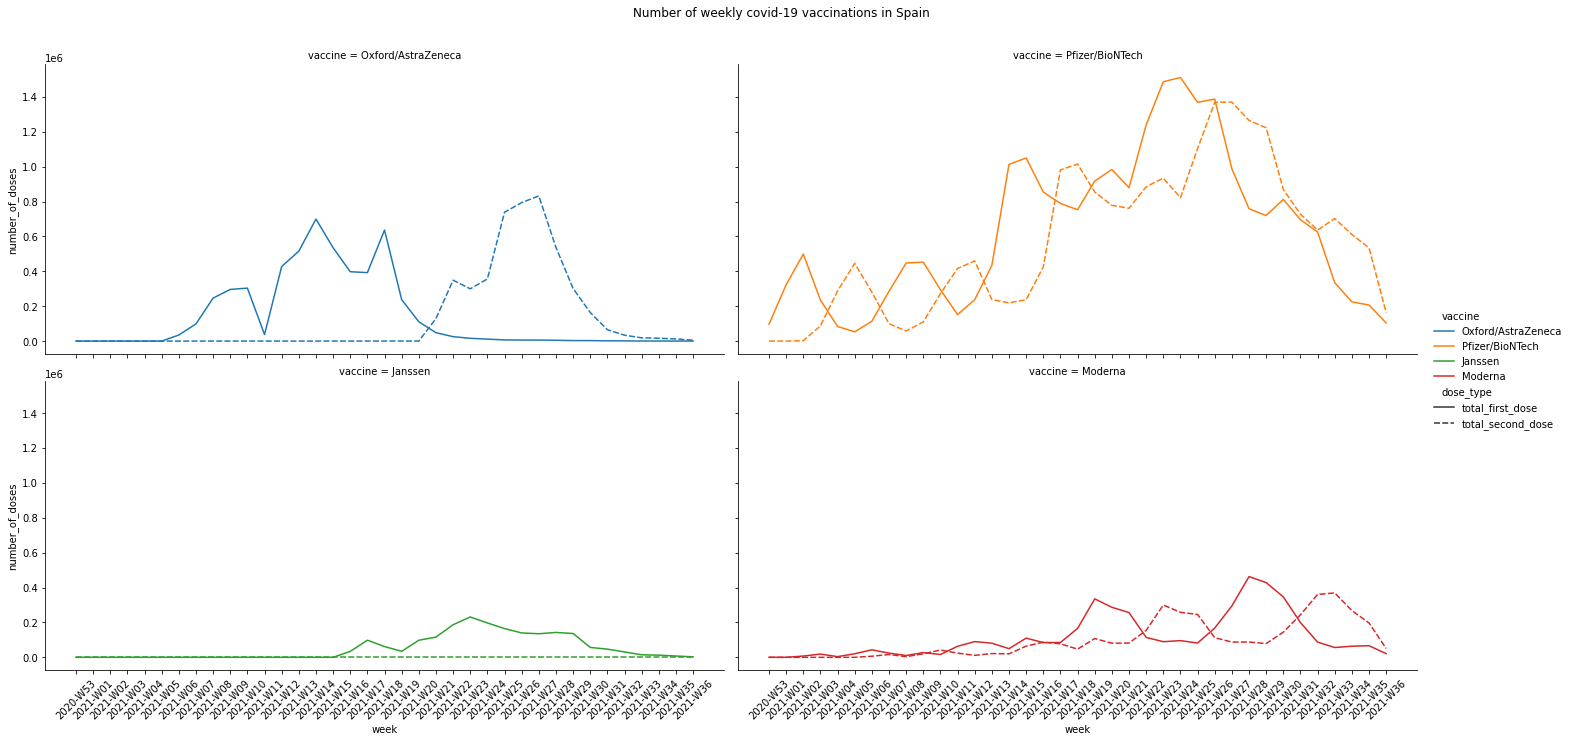

In [29]:
data1 = df1.drop(columns=['population', 'total_first_dose_refused']).melt(id_vars=['week','vaccine'], var_name='dose_type', value_name='number_of_doses' )

plt.figure(figsize=(25, 25));

g = sns.relplot(data=data1, kind='line', x='week', y='number_of_doses', col='vaccine', col_wrap=2, style='dose_type', hue='vaccine', aspect=2 );

# Rotate x-labels
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add super-title
g.fig.subplots_adjust(top=.9);    
g.fig.suptitle('Number of weekly covid-19 vaccinations in Spain');


### Evolució de la vacuna Astrazeneca a Espanya

Durant la pandèmia arrel d'uns pocs casos de coaguls en gent vacunada amb la primera dosis de Astrazeneca, el govern va retardar la segona dosis i finalment va decidir als menos de 60 anys que havien rebut la primera dosis d'Astrazeneca se'ls hi posaria segona dosis de Pfizer contravinent la decisió de la EMA que no veia cap problema en tornar a posar Astrazeneca. Deixava la porta oberta a posar la de Astrazeneca sempre que hi hagués un consentiment signat per l'usuari conforme coneixia els riscos. Finalment sabem que la majoria d'usuaris van optar per posar-se la segona d'Astrazeneca. En el gràfic podem veure com la diferència entre les corves de primera i segona dosis acumulades és similar en la població menor i major de 60 anys.

Cal recordar que les dues corves (primera i segona dosis) no arriben al mateix valor per diversos motius. Per exemple, algú que s'hagi contagiat de covid després de la primera dosis ja no se li posa la segona.

<Figure size 1800x1800 with 0 Axes>

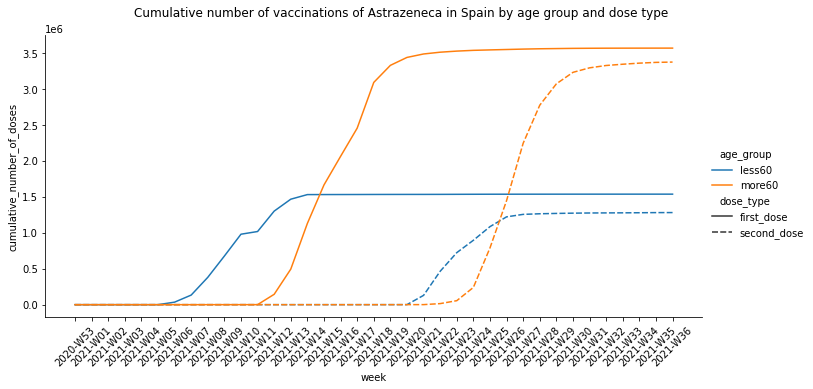

In [30]:
df2['cumulative_less60_first_dose'] = df2.less60_first_dose.cumsum()
df2['cumulative_more60_first_dose'] = df2.more60_first_dose.cumsum()
df2['cumulative_less60_second_dose'] = df2.less60_second_dose.cumsum()
df2['cumulative_more60_second_dose'] = df2.more60_second_dose.cumsum()

data2 = df2.drop(columns=['less60_first_dose','more60_first_dose','less60_second_dose','more60_second_dose']).melt(id_vars=['week'], var_name='age_group-dose', value_name='cumulative_number_of_doses')

data2['age_group'] = data2['age_group-dose'].str[11:17]
data2['dose_type'] = data2['age_group-dose'].str[18:]

plt.figure(figsize=(25, 25));

g = sns.relplot(data=data2, kind='line', x='week', y='cumulative_number_of_doses', style='dose_type', hue='age_group', aspect=2 );

# Rotate x-labels
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add super-title
g.fig.subplots_adjust(top=.9);    
g.fig.suptitle('Cumulative number of vaccinations of Astrazeneca in Spain by age group and dose type');

### Anàlisi de les vacunes utilitzades a Europa segons el tipus de tecnología (inactivada, basada en RNA, etc)

Podem obervar que:
- els paisos han optat majoritariament per les noves vacunes basades en RNA enfront de les vacunes més tradicionals basades en vector viral o virus inactivat.
- hi ha un cert nombre significatiu de dosis que França i Noruega no han especificat de quin tipus són (unknown).

In [31]:
df3['total_country'] = df3.groupby(by=['reporting_country']).total_doses.transform('sum')
df3['percentage'] = 100*df3.total_doses/df3.total_country

<Figure size 1800x3240 with 0 Axes>

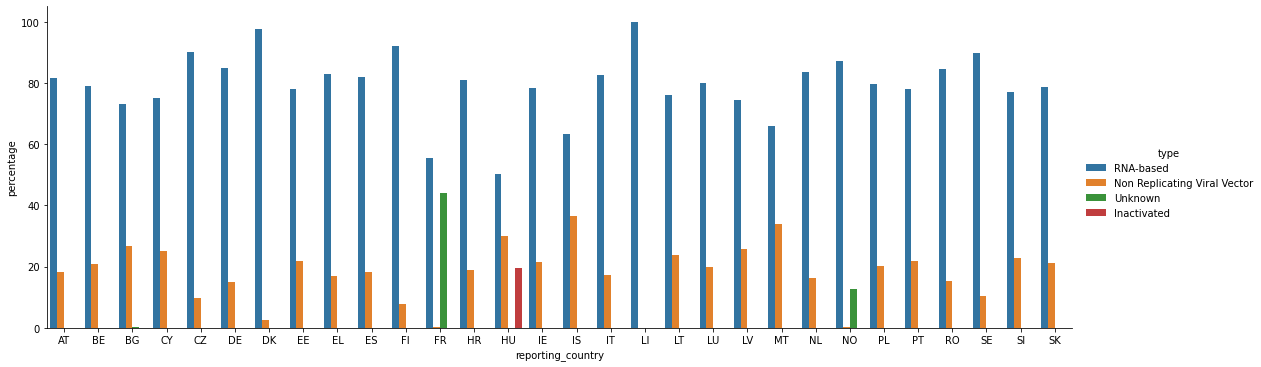

In [ ]:
plt.figure(figsize=(25, 45));

g = sns.catplot(
    data=df3, kind="bar", hue="type",
    x="reporting_country", y="percentage", aspect=3
)